In [2]:
pip install category-encoders

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Import libraries & packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [4]:
#Import dataset
df = pd.read_csv('weatherAUS.csv')
#Drop NaN values on RainTomorrow variable
df.dropna(subset = ['RainTomorrow'], inplace=True)
#Feature Engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date',inplace= True,axis=1)

#Drop very strong positive correlation
df.drop(['Temp9am','Temp3pm','Pressure9am'],inplace= True,axis=1)
#Drop categorical variables (have practically no impact to the model performance as seen in EDA)
df.drop(['Location','WindGustDir','WindDir9am','WindDir3pm'],inplace= True,axis=1)

In [5]:
#Extract independent and dependent variables
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow']
#Split training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']
#replace missing values in X_train and X_test with respective column median in X_train
for df1 in [X_train, X_test]:
    for col in numerical:
        col_median=X_train[col].median()
        df1[col].fillna(col_median, inplace=True)

In [7]:
#Engineering outliers in numerical variables
def max_value(df2, variable, top):
    return np.where(df2[variable]>top, top, df2[variable])

for df2 in [X_train, X_test]:
    df2['Rainfall'] = max_value(df2, 'Rainfall', 2.0)
    df2['Evaporation'] = max_value(df2, 'Evaporation', 14.6)
    df2['WindSpeed9am'] = max_value(df2, 'WindSpeed9am', 37.0)
    df2['WindSpeed3pm'] = max_value(df2, 'WindSpeed3pm', 40.5)

In [8]:
X_train_copy = X_train.copy()
# encode RainToday variable using category encoders because RainToday values are binary
encoder = ce.BinaryEncoder(cols=['RainToday'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
#Creating X_train dataset that has been encoded using pd.get_dummies
X_train = pd.concat([X_train[numerical], X_train[['RainToday_0', 'RainToday_1']]], axis=1)
#Creating X_test dataset that has been encoded using pd.get_dummies
X_test = pd.concat([X_test[numerical], X_test[['RainToday_0', 'RainToday_1']]], axis=1)

In [9]:
#Feature Scaling
scaler = MinMaxScaler()
col = X_train.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[col])
X_test = pd.DataFrame(X_test, columns=[col])

In [10]:
#Modelling Random Forest Classifier
model_rf = RandomForestClassifier(random_state=0)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

In [11]:
def check_model_performance():
  #Check confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  print('Confusion matrix\n\n', cm)
  print('\nTrue Positives(TP) = ', cm[0,0])
  print('\nTrue Negatives(TN) = ', cm[1,1])
  print('\nFalse Positives(FP) = ', cm[0,1])
  print('\nFalse Negatives(FN) = ', cm[1,0])

  #Check accuracy

  print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
  #Check ROC AUC
  ROC_AUC_rf = roc_auc_score(y_test, model_rf.predict_proba(X_test)[:,1])
  print('ROC AUC RF: {:.4f}'.format(ROC_AUC_rf))
  #Check classification report
  print(classification_report(y_test, y_pred))

In [12]:
check_model_performance()

Confusion matrix

 [[21106   961]
 [ 3089  3283]]

True Positives(TP) =  21106

True Negatives(TN) =  3283

False Positives(FP) =  961

False Negatives(FN) =  3089
Model accuracy score: 0.8576
ROC AUC RF: 0.8867
              precision    recall  f1-score   support

          No       0.87      0.96      0.91     22067
         Yes       0.77      0.52      0.62      6372

    accuracy                           0.86     28439
   macro avg       0.82      0.74      0.77     28439
weighted avg       0.85      0.86      0.85     28439



In [13]:
def preprocess_input():
  input = {
    'MinTemp': min_t, 
    'MaxTemp': max_t, 
    'Rainfall': rainfall, 
    'Evaporation': evap, 
    'Sunshine': sun,
    'WindGustSpeed': wind_gust_speed,
    'WindSpeed9am': wind_speed_9, 
    'WindSpeed3pm': wind_speed_3, 
    'Humidity9am': humid_9, 
    'Humidity3pm': humid_3, 
    'Pressure3pm': pres_3, 
    'Cloud9am': cloud_9, 
    'Cloud3pm': cloud_3, 
    'RainToday': rain_today, 
    'Year': year, 
    'Month': month, 
    'Day': day
    }
  input_arr = []
  input_arr.append(input)
  X_input = pd.DataFrame(input_arr)
  #Preprocessing
  # encode RainToday variable using category encoders because RainToday values are binary
  encoder = ce.BinaryEncoder(cols=['RainToday'])
  func_X_train_copy = encoder.fit_transform(X_train_copy)
  X_input = encoder.transform(X_input)
  #Creating X_test dataset that has been encoded using pd.get_dummies
  X_input = pd.concat([X_input[numerical], X_input[['RainToday_0', 'RainToday_1']]], axis=1)
  return X_input

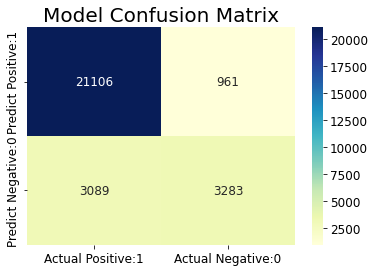

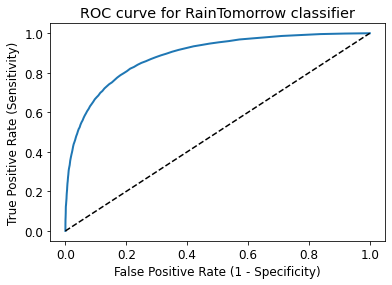

In [16]:
import pickle
Model = pickle.dumps(model_rf)

import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

def create_plot(): 

    cm = confusion_matrix(y_test, y_pred)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                     index=['Predict Positive:1', 'Predict Negative:0'])
    g = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Model Confusion Matrix', fontsize=20)

    return g.figure

def create_plot2():
    #Display ROC Curve
    from sklearn.metrics import roc_curve
    y_score = model_rf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label = 'Yes')
    x = plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for RainTomorrow classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    
    return x.figure

def New_Window():
    Window = tk.Toplevel()
    Window.title('Model Details')
    Window.geometry("500x350")
    Window['bg']='#ffffff'
    #Visualize confusion matrix
    figure = create_plot()
    canvas = FigureCanvasTkAgg(figure, master=Window)
    canvas.draw()
    canvas.get_tk_widget().pack()
    
    button2 = tk.Button(Window, text="Close", bg='White', fg='Black',
                              command=lambda: Window.destroy(),font='Arial 11 bold')
    button2.pack()
    
def New_Window2():
    Window2 = tk.Toplevel()
    Window2.title('Model Details')
    Window2.geometry("500x350")
    Window2['bg']='#ffffff'
    
    figure2 = create_plot2()
    canvas = FigureCanvasTkAgg(figure2, master=Window2)
    canvas.draw()
    canvas.get_tk_widget().pack()
    
    button4 = tk.Button(Window2, text="Close", bg='White', fg='Black',
                              command=lambda: Window2.destroy(),font='Arial 11 bold')
    button4.pack()
    
win = tk.Tk()

win.title('Tomorrow Rain Predictions')

win.geometry("750x250")
win['bg']='#070362'

#Column 1
MinTemp=ttk.Label(win,text="MinTemp")
MinTemp.grid(row=0,column=0,sticky='W')
MinTemp_var=tk.DoubleVar()
MinTemp_entrybox=ttk.Entry(win,width=16,textvariable=MinTemp_var)
MinTemp_entrybox.grid(row=0,column=1)
#Column 2
MaxTemp=ttk.Label(win,text="MaxTemp")
MaxTemp.grid(row=1,column=0,sticky='W')
MaxTemp_var=tk.DoubleVar()
MaxTemp_entrybox=ttk.Entry(win,width=16,textvariable=MaxTemp_var)
MaxTemp_entrybox.grid(row=1,column=1)
#Column 3
Rainfall=ttk.Label(win,text="Rainfall")
Rainfall.grid(row=2,column=0,sticky='W')
Rainfall_var=tk.DoubleVar()
Rainfall_entrybox=ttk.Entry(win,width=16,textvariable=Rainfall_var)
Rainfall_entrybox.grid(row=2,column=1)
#Column 4
Evaporation=ttk.Label(win,text="Evaporation")
Evaporation.grid(row=3,column=0,sticky='W')
Evaporation_var=tk.DoubleVar()
Evaporation_entrybox=ttk.Entry(win,width=16,textvariable=Evaporation_var)
Evaporation_entrybox.grid(row=3,column=1)
#Column 5
Sunshine=ttk.Label(win,text="Sunshine")
Sunshine.grid(row=4,column=0,sticky='W')
Sunshine_var=tk.DoubleVar()
Sunshine_entrybox=ttk.Entry(win,width=16,textvariable=Sunshine_var)
Sunshine_entrybox.grid(row=4,column=1)
#Column 6
WindGustSpeed=ttk.Label(win,text="WindGustSpeed")
WindGustSpeed.grid(row=5,column=0,sticky='W')
WindGustSpeed_var=tk.DoubleVar()
WindGustSpeed_entrybox=ttk.Entry(win,width=16,textvariable=WindGustSpeed_var)
WindGustSpeed_entrybox.grid(row=5,column=1)
#Column 7
WindSpeed9am=ttk.Label(win,text="WindSpeed9am")
WindSpeed9am.grid(row=0,column=2,sticky='W')
WindSpeed9am_var=tk.DoubleVar()
WindSpeed9am_entrybox=ttk.Entry(win,width=16,textvariable=WindSpeed9am_var)
WindSpeed9am_entrybox.grid(row=0,column=3)
#Column 8
WindSpeed3pm=ttk.Label(win,text="WindSpeed3pm")
WindSpeed3pm.grid(row=1,column=2,sticky='W')
WindSpeed3pm_var=tk.DoubleVar()
WindSpeed3pm_entrybox=ttk.Entry(win,width=16,textvariable=WindSpeed3pm_var)
WindSpeed3pm_entrybox.grid(row=1,column=3)
#Column 9
Humidity9am=ttk.Label(win,text="Humidity9am")
Humidity9am.grid(row=2,column=2,sticky='W')
Humidity9am_var=tk.DoubleVar()
Humidity9am_entrybox=ttk.Entry(win,width=16,textvariable=Humidity9am_var)
Humidity9am_entrybox.grid(row=2,column=3)
#Column 10
Humidity3pm=ttk.Label(win,text="Humidity3pm")
Humidity3pm.grid(row=3,column=2,sticky='W')
Humidity3pm_var=tk.DoubleVar()
Humidity3pm_entrybox=ttk.Entry(win,width=16,textvariable=Humidity3pm_var)
Humidity3pm_entrybox.grid(row=3,column=3)
#Column 11
Pressure3pm=ttk.Label(win,text="Pressure3pm")
Pressure3pm.grid(row=4,column=2,sticky='W')
Pressure3pm_var=tk.DoubleVar()
Pressure3pm_entrybox=ttk.Entry(win,width=16,textvariable=Pressure3pm_var)
Pressure3pm_entrybox.grid(row=4,column=3)
#Column 12
Cloud9am=ttk.Label(win,text="Cloud9am")
Cloud9am.grid(row=5,column=2,sticky='W')
Cloud9am_var=tk.DoubleVar()
Cloud9am_entrybox=ttk.Entry(win,width=16,textvariable=Cloud9am_var)
Cloud9am_entrybox.grid(row=5,column=3)
#Column 13
Cloud3pm=ttk.Label(win,text="Cloud3pm")
Cloud3pm.grid(row=0,column=4,sticky='W')
Cloud3pm_var=tk.DoubleVar()
Cloud3pm_entrybox=ttk.Entry(win,width=16,textvariable=Cloud3pm_var)
Cloud3pm_entrybox.grid(row=0,column=5)
#Column 14
Year=ttk.Label(win,text="Year")
Year.grid(row=1,column=4,sticky='W')
Year_var=tk.IntVar()
Year_entrybox=ttk.Entry(win,width=16,textvariable=Year_var)
Year_entrybox.grid(row=1,column=5)
#Column 15
Month=ttk.Label(win,text="Month")
Month.grid(row=2,column=4,sticky='W')
Month_var=tk.IntVar()
Month_entrybox=ttk.Entry(win,width=16,textvariable=Month_var)
Month_entrybox.grid(row=2,column=5)
#Column 16
Day=ttk.Label(win,text="Day")
Day.grid(row=3,column=4,sticky='W')
Day_var=tk.IntVar()
Day_entrybox=ttk.Entry(win,width=16,textvariable=Day_var)
Day_entrybox.grid(row=3,column=5)
#Column 17
RainToday=ttk.Label(win,text="RainToday")
RainToday.grid(row=4,column=4,sticky='W')
RainToday_var=tk.StringVar()
RainToday_entrybox=ttk.Entry(win,width=16,textvariable=RainToday_var)
RainToday_entrybox.grid(row=4,column=5)


global DB
import pandas as pd
def Output():
    global MinTemp_entrybox
    global MaxTemp_entrybox
    global Rainfall_entrybox
    global Evaporation_entrybox
    global Sunshine_entrybox
    global WindGustSpeed_entrybox
    global WindSpeed9am_entrybox
    global WindSpeed3pm_entrybox
    global Humidity9am_entrybox
    global Humidity3pm_entrybox
    global Pressure3pm_entrybox
    global Cloud9am_entrybox
    global Cloud3pm_entrybox
    global Year_entrybox
    global Month_entrybox
    global Day_entrybox
    global RainToday_entrybox
    global min_t
    global max_t
    global rainfall
    global evap
    global sun
    global wind_gust_speed
    global wind_speed_9
    global wind_speed_3
    global humid_9
    global humid_3
    global pres_3
    global cloud_9
    global cloud_3
    global year
    global month
    global day
    global rain_today
    min_t=MinTemp_entrybox.get()
    max_t=MaxTemp_entrybox.get()
    rainfall=Rainfall_entrybox.get()
    evap=Evaporation_entrybox.get()
    sun=Sunshine_entrybox.get()
    wind_gust_speed=WindGustSpeed_entrybox.get()
    wind_speed_9=WindSpeed9am_entrybox.get()
    wind_speed_3=WindSpeed3pm_entrybox.get()
    humid_9=Humidity9am_entrybox.get()
    humid_3=Humidity3pm_entrybox.get()
    pres_3=Pressure3pm_entrybox.get()
    cloud_9=Cloud9am_entrybox.get()
    cloud_3=Cloud3pm_entrybox.get()
    year=Year_entrybox.get()
    month=Month_entrybox.get()
    day=Day_entrybox.get()
    rain_today=RainToday_entrybox.get()
    
    DB=preprocess_input()
    output=model_rf.predict(DB)
    result=output
    Predict_entrybox=ttk.Entry(win,width=16)
    Predict_entrybox.grid(row=10,column=1)
    Predict_entrybox.insert(1,str(result))
    
Predict_button=ttk.Button(win,text="Predict",command=Output)
Predict_button.grid(row=10,column=0,sticky='W')

button = tk.Button(win, text="Check Model Visualization >>", bg='White', fg='Black',
                              command=lambda: New_Window())
button.grid(row=12,column=0,sticky='W')
button3 = tk.Button(win, text="Check Model ROC Curve >>", bg='White', fg='Black',
                              command=lambda: New_Window2())
button3.grid(row=13,column=0,sticky='W')
button5 = tk.Button(win, text="Exit", bg='White', fg='Black',
                              command=lambda: win.destroy())
button5.grid(row=14,column=0,sticky='W')
win.mainloop()